In [1]:
import pandas as pd             # data package
import matplotlib.pyplot as plt # graphics 
import datetime as dt
import numpy as np

# these are new 
import requests, io             # internet and input tools  
import zipfile as zf            # zip file tools 
import shutil                   # file management tools 
import os                       # operating system tools (check files)

import geopandas as gpd # this is the main geopandas 
from shapely.geometry import Point, Polygon # also needed

import pyarrow as pa
import pyarrow.parquet as pq

##########################
# Then this stuff below allows us to make a nice inset


from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

#####################################################33
# on my laptop this issue arose and the suggested fix worked
# https://github.com/pyproj4/pyproj/issues/134

### Step 1: Get Shapefiles

The next couple of cells download the requisite shapefiles from the US census. They are unzipped in a folder called shapefiles and then county. So they are assuming some structure behind your folder setup. 

In [6]:
print("")
print("**********************************************************************************")
print("Downloading Shape files")
print("")

cwd = os.getcwd()

county_url = "https://www2.census.gov/geo/tiger/TIGER2017/COUNTY/tl_2017_us_county.zip"
    
r = requests.get(county_url ) 

county_shapefile = zf.ZipFile(io.BytesIO(r.content)) 

county_shapefile.extractall(path = cwd + "\\shapefiles\\county")

del r, county_shapefile


**********************************************************************************



Then do the same thing for states (so we can draw state lines as well). What's cool about these shapefiles is then you can layer on other stuff, roads, rivers, lakes.

In [7]:
state_url = "https://www2.census.gov/geo/tiger/TIGER2017/STATE/tl_2017_us_state.zip"
    
r = requests.get(state_url) 

state_shapefile = zf.ZipFile(io.BytesIO(r.content)) 

state_shapefile.extractall(path = cwd + "\\shapefiles\\state")

del r, state_shapefile

### Step 2: Some basic cleaning

We will grab the tariff data, compute the tariff change. Then we will merge it with the geopandas dataframe

In [2]:
# Grab the tradedata...

file_path = os.getcwd()

fig_path = file_path +"\\figures"

trade_data = pq.read_table(file_path + "\\data\\total_trade_data_2015.parquet").to_pandas()

trade_data["time"] = pd.to_datetime(trade_data.time)

trade_data.set_index(["area_fips", "time"],inplace = True)

In [3]:
trade_data["tariff_change"] = trade_data.groupby(["area_fips"]).tariff.diff(12)

trade_data.sort_values(["area_fips", "time"], inplace = True)

In [4]:
trade_data.head()

total_exp_pc  china_exp_pc    tariff  emplvl_2017  \
area_fips time                                                            
10001     2015-01-01    523.035475     57.171736  1.069526       2843.0   
          2015-02-01    505.746088     47.313771  1.069501       2843.0   
          2015-03-01    558.254429     45.962111  1.069501       2843.0   
          2015-04-01    526.297224     38.689461  1.069500       2843.0   
          2015-05-01    511.775455     35.258126  1.069500       2843.0   

                       fips  total_employment  tariff_change  
area_fips time                                                
10001     2015-01-01  10001           29514.0            NaN  
          2015-02-01  10001           29514.0            NaN  
          2015-03-01  10001           29514.0            NaN  
          2015-04-01  10001           29514.0            NaN  
          2015-05-01  10001           29514.0            NaN

Now we will grab the county-level shapefile

In [209]:
cwd = os.getcwd()

county_shape = cwd + "\\shapefiles\\county\\tl_2017_us_county.shx"

us_map = gpd.read_file(county_shape)

us_map = us_map.to_crs({'init': 'epsg:3395'})

In [210]:
us_map["geometry"] = us_map["geometry"].simplify(200)

In [211]:
us_map.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477641638,10701538,+41.9158651,-096.7885168,POLYGON ((-10800163.11812986 5132991.983053582...
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680956787,61588406,+46.2946377,-123.4244583,"POLYGON ((-13740876.52543789 5787729.82287615,..."
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016761648,29147345,+34.3592729,-104.3686961,POLYGON ((-11640388.27442317 4004583.794358812...
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169252486,22867561,+40.7835474,-096.6886584,POLYGON ((-10788038.53315113 4978192.963294434...
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645186,1718484,+40.1764918,-098.0468422,POLYGON ((-10939774.56882773 4851419.990907463...


A little bit more cleaning so a merge can be done.

In [212]:
us_map["area_fips"] = (us_map.STATEFP.astype(str) + us_map.COUNTYFP.astype(str)).astype(int)

In [213]:
tariff_df = trade_data.xs('2018-12-1', level=1).copy()

tariff_df["fips_code"] = tariff_df.index

tariff_df["fips_code"] = tariff_df["fips_code"].astype(int)

In [214]:
tariff_df.head()

,total_exp_pc,china_exp_pc,tariff,emplvl_2017,fips,total_employment,tariff_change,fips_code
area_fips,,,,,,,,
10001,524.630933,23.745690,2.426361,2843.0,10001,29514.0,1.357466,10001
10003,499.745029,39.971812,0.456547,9072.0,10003,249775.0,0.245212,10003
10005,920.169247,52.514965,3.579051,9358.0,10005,60389.0,1.942987,10005
1001,2032.472813,220.403712,2.185990,891.0,1001,6100.0,0.844549,1001
1003,728.597752,55.161192,1.358526,4993.0,1003,58645.0,0.822081,1003


Then merge the geopandas dataframe with the regular dataframe

In [215]:
us_map = us_map.merge(tariff_df[["tariff_change","fips_code"]], left_on='area_fips',
                      right_on = "fips_code", how = "inner", indicator = True)

In [216]:
us_map.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,area_fips,tariff_change,fips_code,_merge
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,...,A,1477641638,10701538,+41.9158651,-096.7885168,POLYGON ((-10800163.11812986 5132991.983053582...,31039,3.029046,31039,both
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,...,A,680956787,61588406,+46.2946377,-123.4244583,"POLYGON ((-13740876.52543789 5787729.82287615,...",53069,2.343937,53069,both
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,...,A,6016761648,29147345,+34.3592729,-104.3686961,POLYGON ((-11640388.27442317 4004583.794358812...,35011,0.000000,35011,both
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,...,A,2169252486,22867561,+40.7835474,-096.6886584,POLYGON ((-10788038.53315113 4978192.963294434...,31109,0.713917,31109,both
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,...,A,1489645186,1718484,+40.1764918,-098.0468422,POLYGON ((-10939774.56882773 4851419.990907463...,31129,0.450309,31129,both


Now we will drop Alaska and there stuff, bring in the state files too. Then plot.

In [217]:
us_map.set_index("STATEFP", inplace = True)

drop_list = ["02","15","72"]

us_map.drop(drop_list, inplace = True)

In [218]:
state_shape = cwd + "\\shapefiles\\state\\tl_2017_us_state.shx"

state_map = gpd.read_file(state_shape)

state_map = state_map.to_crs({'init': 'epsg:3395'})

state_map["geometry"] = state_map["geometry"].simplify(200)

In [219]:
state_map.set_index("STATEFP", inplace = True)

drop_list = ["02","15","72","78","69","66","60",]

state_map.drop(drop_list, inplace = True)

### Step 3: Plot it. 

That's what we do below

In [220]:
us_map["q_tariff"] = pd.qcut(us_map["tariff_change"], 10,labels = False, duplicates='drop')

us_map.q_tariff.replace(np.nan,0,inplace = True)

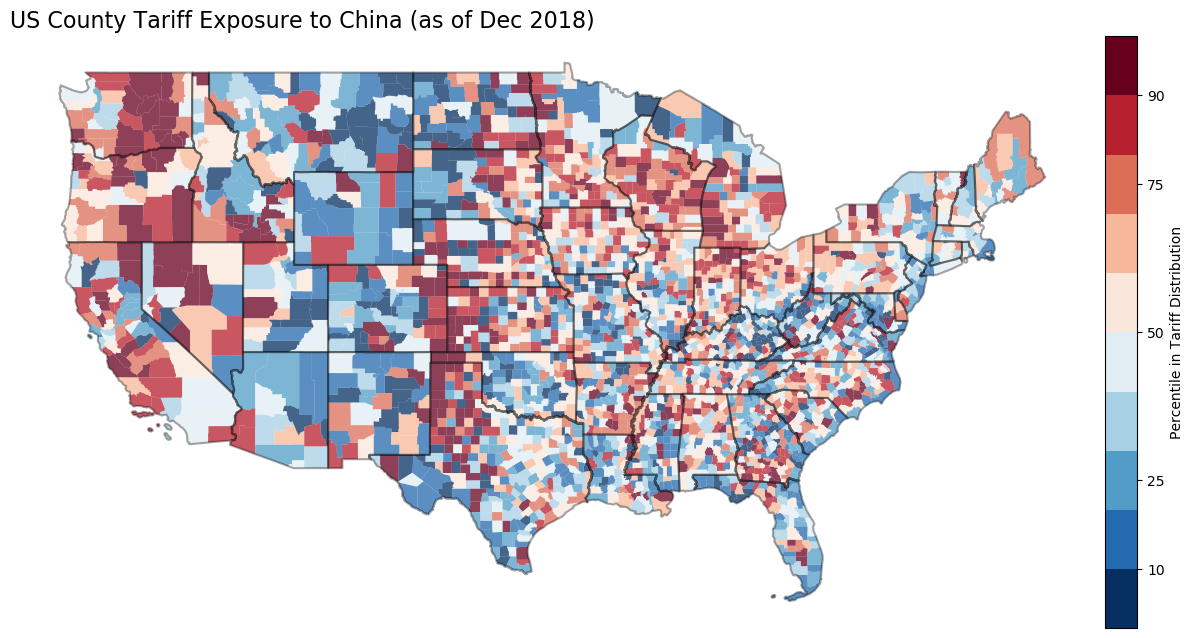

In [221]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1,1,figsize = (12,8))

plt.tight_layout()
plt.rcParams.update(plt.rcParamsDefault) # This will reset defaluts...

#################################################################################
# This is for the colorbar...

divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="3%", pad=0.1)

#################################################################################
## This creates a discrete colorbar scheme...
# https://gist.github.com/jakevdp/91077b0cae40f8f8244a

N = 10

base = plt.cm.get_cmap("RdBu_r")

color_list = base(np.linspace(0, 1, N))

cmap_name = base.name + str(N)

dcmap =  base.from_list(cmap_name, color_list, N)

#################################################################################
# This is the normal mapping...

us_map.plot(column='q_tariff', ax = ax,
              # THIS IS NEW, it says color it based on this column
             cmap=dcmap, 
             alpha = 0.75,
             vmin=0, vmax=us_map.q_tariff.max())

#################################################################################
# This then alows me to generate and edit the colorbar....
# https://stackoverflow.com/questions/53158096/editing-colorbar-legend-in-geopandas

sm = plt.cm.ScalarMappable(cmap=dcmap)
sm._A = []
cbr = fig.colorbar(sm, cax=cax)

cbr.set_label('Percentile in Tariff Distribution')
cbr.set_alpha(0.15)

cbr.set_ticks([0.10, 0.25,0.50,0.75, 0.90])
cbr.set_ticklabels(["10","25","50","75","90"], update_ticks=True)

#################################################################################

state_map.geometry.boundary.plot(color=None, edgecolor='k', alpha = 0.35, ax = ax)

#################################################################################
# Then some final stuff to clean things up....

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax.get_xaxis().set_visible(False)

ax.get_yaxis().set_visible(False)

ax.set_title("US County Tariff Exposure to China (as of Dec 2018)", fontsize = 16, loc= "left" )

#ax.text(-127,23, "Source: US Census, BLS", fontsize = 8)

#fig_path = "C:\\github\\expenditure_tradeshocks\\figures"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
    
plt.savefig(fig_path +"\\us_china_exports_map.png", bbox_inches = "tight", dip = 1200)

plt.show()

In [222]:
import json
from bokeh.io import show
from bokeh.models import (CDSView, ColorBar, ColumnDataSource,
                          CustomJS, CustomJSFilter, 
                          GeoJSONDataSource, HoverTool,
                          LinearColorMapper, Slider)
from bokeh.layouts import column, row, widgetbox
from bokeh.palettes import brewer
from bokeh.plotting import figure

from bokeh.plotting import figure, save

from bokeh.resources import CDN
from bokeh.embed import file_html

# Input GeoJSON source that contains features for plotting
#geosource = GeoJSONDataSource(geojson = us_map.to_json())

In [227]:
state_geosource = GeoJSONDataSource(geojson = state_map.to_json())

geosource = GeoJSONDataSource(geojson = us_map.to_json())

palette = brewer['RdBu'][9]

#https://docs.bokeh.org/en/latest/docs/reference/palettes.html

color_mapper = LinearColorMapper(palette = palette, low = 0, high = 10)

# Create figure object.
p = figure(title = 'US County Tariff Exposure to China (as of Dec 2018)', 
           plot_height = 600 ,
           plot_width = 850, 
           toolbar_location = 'below',
           tools = "box_zoom, reset")

p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
# Add patch renderer to figure.

states = p.patches('xs','ys', source = geosource,
                   fill_color = {"field" :'q_tariff',
                                 "transform" : color_mapper},
                   line_color = "gray", 
                   line_width = 0.25, 
                   fill_alpha = 1)

state_line = p.multi_line('xs','ys', source = state_geosource,
                   line_color = "black", 
                   line_width = 0.5)
# Create hover tool

p.add_tools(HoverTool(renderers = [states],
                      tooltips = [('County','@NAME'),
                                ('Tariff','@tariff_change')]))

outfp = fig_path + "\\us_china_exports_map.html"

# Save the map
save(p, outfp)

html = file_html(p, CDN, outfp)

In [224]:
us_map.q_tariff.max()

9.0

In [225]:
color_mapper.

SyntaxError: invalid syntax (<ipython-input-225-ef9c42e181a4>, line 1)